# **XPM 1D HG Simulation**


In [2]:
# general imports
import numpy as np
import matplotlib.pyplot as plt
import time
import math

# ml imports
import torch
import torch.nn.functional as F
from tqdm import tqdm

# import module
from nlse import *

## **Defining Hermite-Hauss HG Basis Functions**
The Hermite–Gauss functions form an orthonormal basis for square-integrable functions $f(t)$ on the real line, i.e. for $f \in L^2(\R)$ and are defined as:
$$
\psi_n(t) = \frac{1}{\sqrt{2^n n! \sqrt{\pi}}} \, H_n(t) \, e^{-t^2/2}, 
\quad n = 0, 1, 2, \ldots
$$
However, we can define a scaled Hermite-Gauss basis, where we can adjust the characteristic time scale $t_0 > 0$ and hence the puslse width:
$$
\psi_n(t; t_0) = \frac{1}{\sqrt{t_0}} \, 
\psi_n\!\left(\frac{t}{t_0}\right)
= \frac{1}{\sqrt{2^n n! \sqrt{\pi} \, t_0}} \,
H_n\!\left(\frac{t}{t_0}\right)
\, e^{-t^2 / (2 t_0^2)} .
$$

*They are eigenfunctions of the Fourier transform (up to phase factors) and of the harmonic oscillator Hamiltonian in quantum mechanics.

**Practical Consideration:** However, for large $n$ the normalizing term "explodes" so in practice, HG functions are calculated reecursively:
$$
\psi_0(t) = \frac{1}{\sqrt{t_0}}\pi^{-1/4} e^{-(\frac{t}{t_0})^2/2}, \qquad 
\psi_1(t) = \sqrt{2}\, \frac{t}{t_0}\, \psi_0(\frac{t}{t_0}), \qquad
$$
and then
$$
\psi_{n+1}(t) = \sqrt{\frac{2}{n+1}}\, \frac{t}{t_0}\, \psi_n(t)
 - \sqrt{\frac{n}{n+1}}\, \psi_{n-1}(t).
$$

**Expressing in HG basis:**
We can find the coefficients $c_n$ of $A(t)$ in the HG basis using:
$$
c_n = \int_{-\infty}^{\infty} \psi_n^*(t; t_0)\, A(t)\, dt 
= \int_{-\infty}^{\infty} \psi_n(t; t_0)\, A(t)\, dt.
$$
where we used the fact that the HG basis is real.

Since this is a simple basis change (a unitary transformation) $|c_n|^2$ tells us "how much energy" of $A(t)$ sits in mode $n$. We can retrieve $A(t)$ in the time domain as:
$$
A_{\text{recon}}(t) = \sum_{n=0}^{n_{\max}} c_n\, \psi_n(t; t_0).
$$

$$


\psi_0(t; t_0)
= \frac{1}{\pi^{1/4} \, t_0^{1/2}}
\, \exp\!\left[-\frac{t^2}{2 t_0^2}\right],

\\

\psi_1(t; t_0)
= \frac{\sqrt{2}\, t}{\pi^{1/4} \, t_0^{3/2}}
\, \exp\!\left[-\frac{t^2}{2 t_0^2}\right],

\\

\psi_2(t; t_0)
= \frac{1}{\sqrt{2} \, \pi^{1/4} \, t_0^{1/2}}
\left(
2 \frac{t^2}{t_0^2} - 1
\right)
\, \exp\!\left[-\frac{t^2}{2 t_0^2}\right].

$$

### Utility Functions

In [3]:
""" Define Basis Functions """
def hermite_poly(n, t):
    """
    Compute the physicists' Hermite polynomial H_n(x) recursively.
    Works for scalar or tensor x.
    """
    if n == 0:
        return torch.ones_like(t)
    elif n == 1:
        return 2 * t
    
    else:
        Hn_2 = torch.ones_like(t)  # H_0
        Hn_1 = 2 * t               # H_1
        for k in range(2, n + 1):
            Hn = 2 * t * Hn_1 - 2 * (k - 1) * Hn_2
            Hn_2, Hn_1 = Hn_1, Hn
        return Hn
    
    
def hermite_gauss(n, t, t0=1.0):
    """
    Compute the n-th scaled Hermite–Gauss function ψ_n(t; t0)
    
    Parameters
    ----------
    n : int
        Order of the mode
    t : torch.Tensor
        1D tensor of time points (any device)
    t0 : float
        Characteristic time scale

    Returns
    -------
    ψ_n(t; t0) : torch.Tensor
        The evaluated Hermite–Gauss function
    """
    x = t / t0
    Hn = hermite_poly(n, x)
    norm = 1.0 / math.sqrt((2**n) * math.factorial(n) * math.sqrt(math.pi) * t0)
    return norm * Hn * torch.exp(-0.5 * x**2)


def hermite_gauss_stable(n, t, t0=1.0):
    """
    Stable computation of ψ_n(t; t0) using orthonormal recursion.
    """
    x = t / t0
    psi_prev = torch.zeros_like(x)
    psi_curr = (1 / (math.pi**0.25 * math.sqrt(t0))) * torch.exp(-0.5 * x**2)
    
    if n == 0:
        return psi_curr
    for k in range(1, n + 1):
        psi_next = math.sqrt(2 / k) * x * psi_curr - math.sqrt((k - 1) / k) * psi_prev
        psi_prev, psi_curr = psi_curr, psi_next
    return psi_curr


""" Define Conversion Functions """
def time_to_hg(A, t, n_modes, t0=1.0):
    """
    Convert a time-domain pulse to Hermite-Gauss basis coefficients.
    
    Parameters
    ----------
    A : torch.Tensor
        1D tensor representing the pulse in time domain
    t : torch.Tensor
        1D tensor of time points corresponding to A
    n_modes : int
        Highest number of basis modes to use (will compute coefficients for modes 0 to n_modes-1)
    t0 : float
        Characteristic time scale for the HG basis
        
    Returns
    -------
    coefficients : torch.Tensor
        1D tensor of size n_modes containing the coefficients c_n in the HG basis
    """
    dt = t[1] - t[0]  # Assume uniform spacing
    coefficients = torch.zeros(n_modes, dtype=A.dtype, device=A.device)
    
    for n in range(n_modes):
        psi_n = hermite_gauss_stable(n, t, t0)
        # Compute integral using trapezoidal rule: c_n = ∫ ψ_n(t) * A(t) dt
        integrand = psi_n * A
        coefficients[n] = torch.trapz(integrand, dx=dt)
    
    return coefficients


def hg_to_time(coefficients, t, t0=1.0):
    """
    Convert Hermite-Gauss basis coefficients back to time-domain pulse.
    
    Parameters
    ----------
    coefficients : torch.Tensor
        1D tensor of size n_modes containing the coefficients c_n in the HG basis
    t : torch.Tensor
        1D tensor of time points where the pulse should be reconstructed
    t0 : float
        Characteristic time scale for the HG basis
        
    Returns
    -------
    A : torch.Tensor
        1D tensor representing the reconstructed pulse in time domain
    """
    n_modes = coefficients.size(0)
    A = torch.zeros_like(t, dtype=coefficients.dtype, device=coefficients.device)
    
    for n in range(n_modes):
        psi_n = hermite_gauss_stable(n, t, t0)
        A += coefficients[n] * psi_n
    
    return A


Precomputed 50 HG basis functions on grid of 1000 points


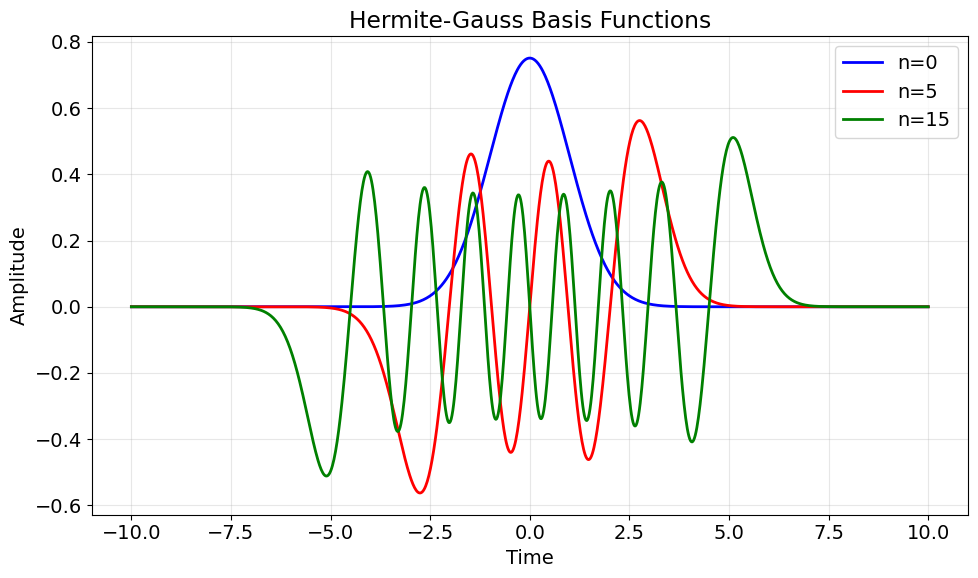

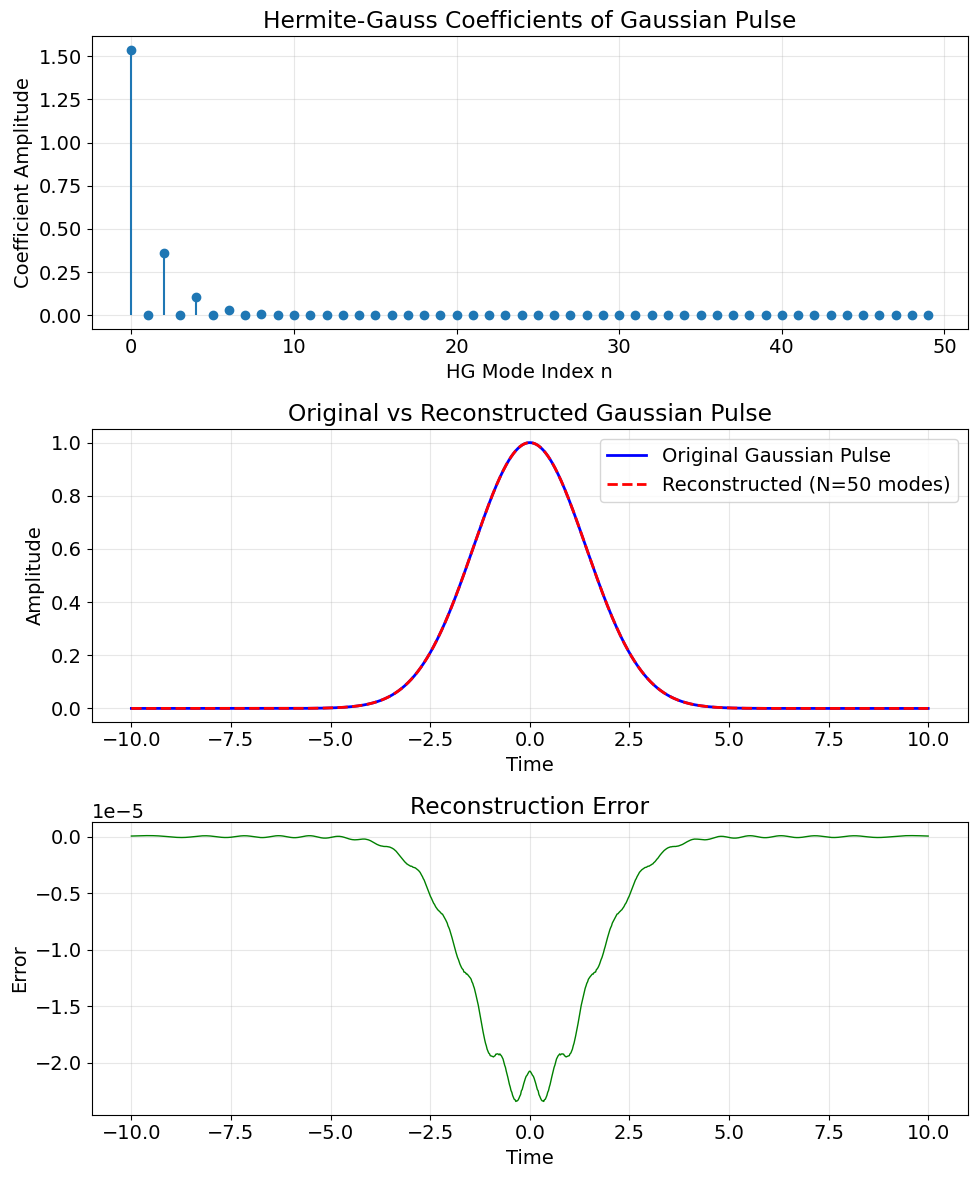

Original pulse energy: 2.506686
Reconstructed pulse energy: 2.506801
RMS error: 0.000008
Max coefficient magnitude: 1.537329
Number of significant coefficients (>1% of max): 4


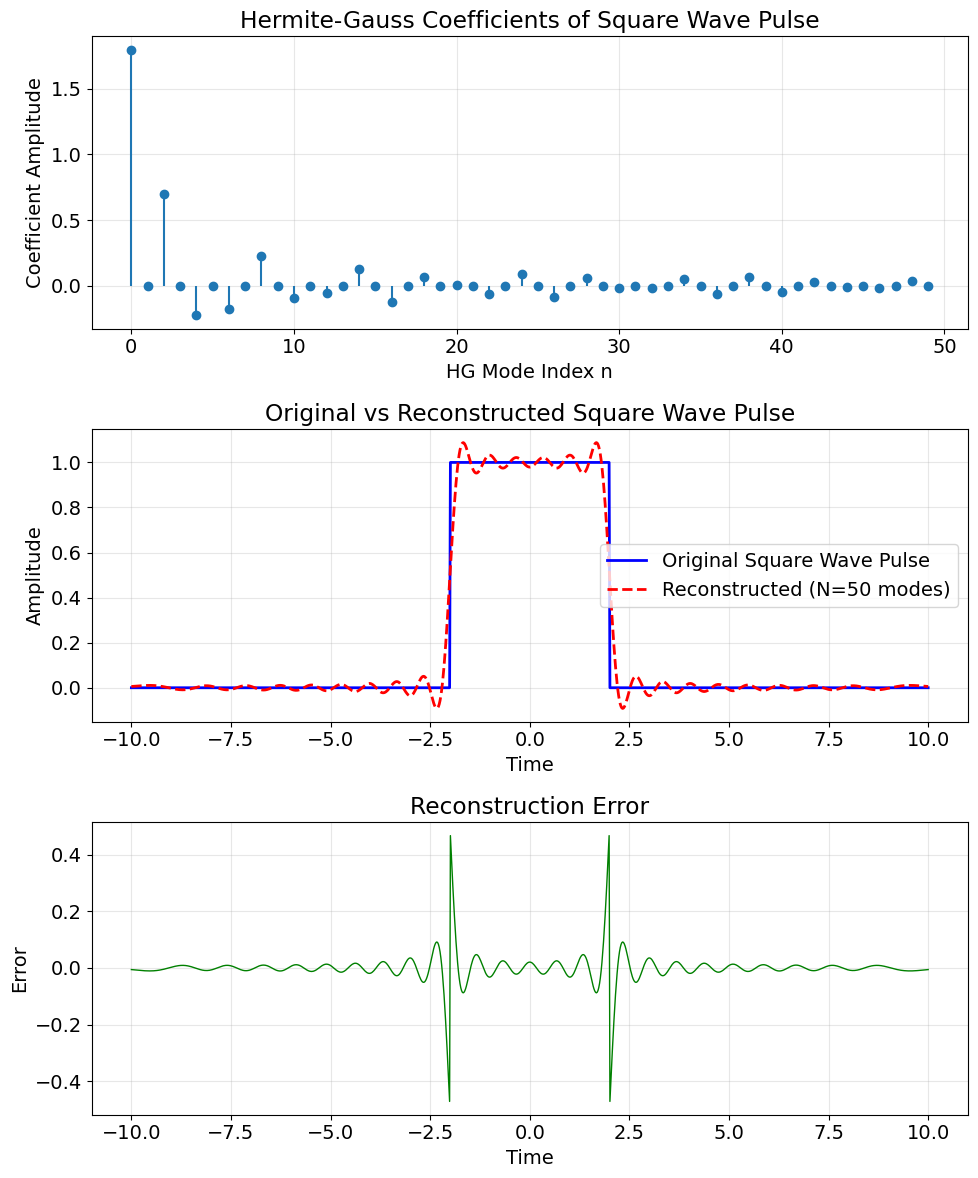

Original pulse energy: 4.004097
Reconstructed pulse energy: 3.937477
RMS error: 0.057754
Max coefficient magnitude: 1.797579
Number of significant coefficients (>1% of max): 22


In [10]:
def get_hg_basis(N_modes, t, t0=1.0):
    # Precompute all HG basis functions as a 2D tensor
    # Shape: (N_modes, len(t)) where each row is ψ_n(t)
    hg_basis = torch.zeros(N_modes, len(t), dtype=torch.float64)

    for n in range(N_modes):
        hg_basis[n] = hermite_gauss_stable(n, t, t0)
        
    print(f"Precomputed {N_modes} HG basis functions on grid of {len(t)} points")
    
    return hg_basis

# Set parameters for efficient HG basis computation
N_modes = 50  # Number of HG modes to precompute
t = torch.linspace(-10, 10, 1000)  # Time grid
t0 = 1.0  # Characteristic time scale

hg_basis = get_hg_basis(N_modes, t, t0)

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot n=1, n=10, and n=15 modes
modes_to_plot = [0, 5, 15]
colors = ['blue', 'red', 'green']
labels = [f'n={n}' for n in modes_to_plot]

for i, n in enumerate(modes_to_plot):
    if n < N_modes:  # Make sure the mode exists in our precomputed basis
        ax.plot(t, hg_basis[n], color=colors[i], label=labels[i], linewidth=2)
    else:
        print(f"Warning: Mode n={n} not available (only computed up to n={N_modes-1})")

ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.set_title('Hermite-Gauss Basis Functions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


def time_to_hg_efficient(A, hg_basis, dt):
    # Matrix multiplication: each row of hg_basis dotted with A
    # Shape: (N_modes,) = (N_modes, len(t)) @ (len(t),)
    integrand = hg_basis * A[None, :]  # Broadcast A to match hg_basis shape
    coefficients = torch.trapz(integrand, dx=dt, dim=1)
    return coefficients


def hg_to_time_efficient(coefficients, hg_basis):
    # Matrix-vector multiplication: coefficients^T @ hg_basis
    # Shape: (len(t),) = (N_modes,) @ (N_modes, len(t))
    A = torch.sum(coefficients[:, None] * hg_basis, dim=0)
    return A

def analyze_pulse_in_hg_basis(pulse, hg_basis, t, pulse_name="Pulse"):
    
    dt = t[1]-t[0]
    hg_coefficients = time_to_hg_efficient(pulse, hg_basis, dt)

    # Reconstruct the pulse from the truncated HG basis
    reconstructed_pulse = hg_to_time_efficient(hg_coefficients, hg_basis)
    
    # Plot the HG coefficients
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
    
    # Plot 1: HG coefficients
    mode_indices = torch.arange(N_modes)
    ax1.stem(mode_indices.numpy(), hg_coefficients.numpy(), basefmt=' ')
    ax1.set_xlabel('HG Mode Index n')
    ax1.set_ylabel('Coefficient Amplitude')
    ax1.set_title(f'Hermite-Gauss Coefficients of {pulse_name}')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Original vs reconstructed pulse
    ax2.plot(t.numpy(), pulse.numpy(), 'b-', linewidth=2, label=f'Original {pulse_name}')
    ax2.plot(t.numpy(), reconstructed_pulse.numpy(), 'r--', linewidth=2, label=f'Reconstructed (N={N_modes} modes)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Amplitude')
    ax2.set_title(f'Original vs Reconstructed {pulse_name}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Reconstruction error
    error = pulse - reconstructed_pulse
    ax3.plot(t.numpy(), error.numpy(), 'g-', linewidth=1)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Error')
    ax3.set_title('Reconstruction Error')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print some statistics
    print(f"Original pulse energy: {torch.trapz(pulse**2, dx=dt):.6f}")
    print(f"Reconstructed pulse energy: {torch.trapz(reconstructed_pulse**2, dx=dt):.6f}")
    print(f"RMS error: {torch.sqrt(torch.mean(error**2)):.6f}")
    print(f"Max coefficient magnitude: {torch.max(torch.abs(hg_coefficients)):.6f}")
    print(f"Number of significant coefficients (>1% of max): {torch.sum(torch.abs(hg_coefficients) > 0.01 * torch.max(torch.abs(hg_coefficients)))}")
    
    return hg_coefficients, reconstructed_pulse, error


""" Run analysis: Gaussian Pulse """
# Define a Gaussian pulse
t_center = 0.0  # Center of the pulse
sigma = 2.0     # Width of the pulse
amplitude = 1.0 # Amplitude of the pulse

# Create the Gaussian pulse
gaussian_pulse = amplitude * torch.exp(-((t - t_center) / sigma)**2)

# Analyze the Gaussian pulse using the HG basis
hg_coefficients, reconstructed_pulse, error = analyze_pulse_in_hg_basis(gaussian_pulse, hg_basis, t, "Gaussian Pulse")

# Define a square wave pulse
t_start = -2.0  # Start of the square wave
t_end = 2.0     # End of the square wave
amplitude = 1.0 # Amplitude of the square wave

# Create the square wave pulse
square_pulse = torch.zeros_like(t)
mask = (t >= t_start) & (t <= t_end)
square_pulse[mask] = amplitude

# Analyze the square wave pulse using the HG basis
hg_coefficients_square, reconstructed_pulse_square, error_square = analyze_pulse_in_hg_basis(square_pulse, hg_basis, t, "Square Wave Pulse")



### Display

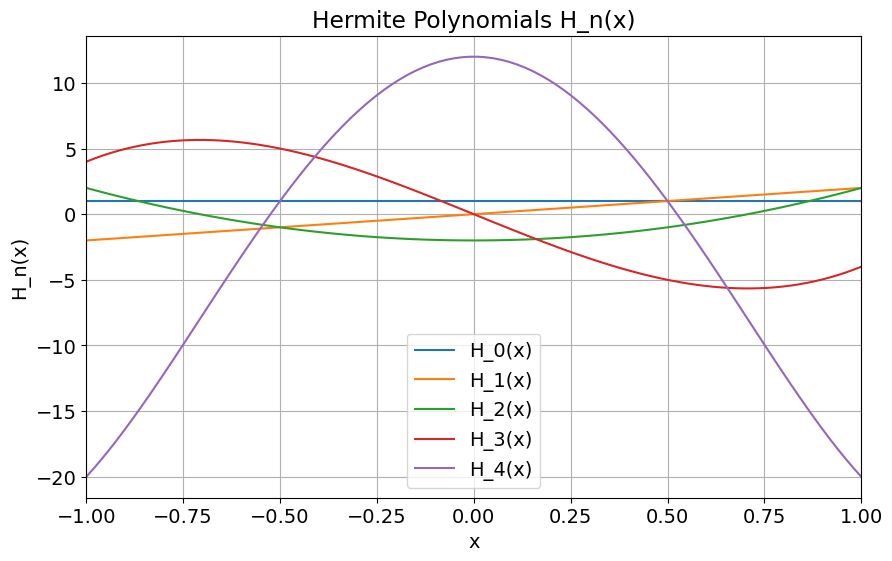

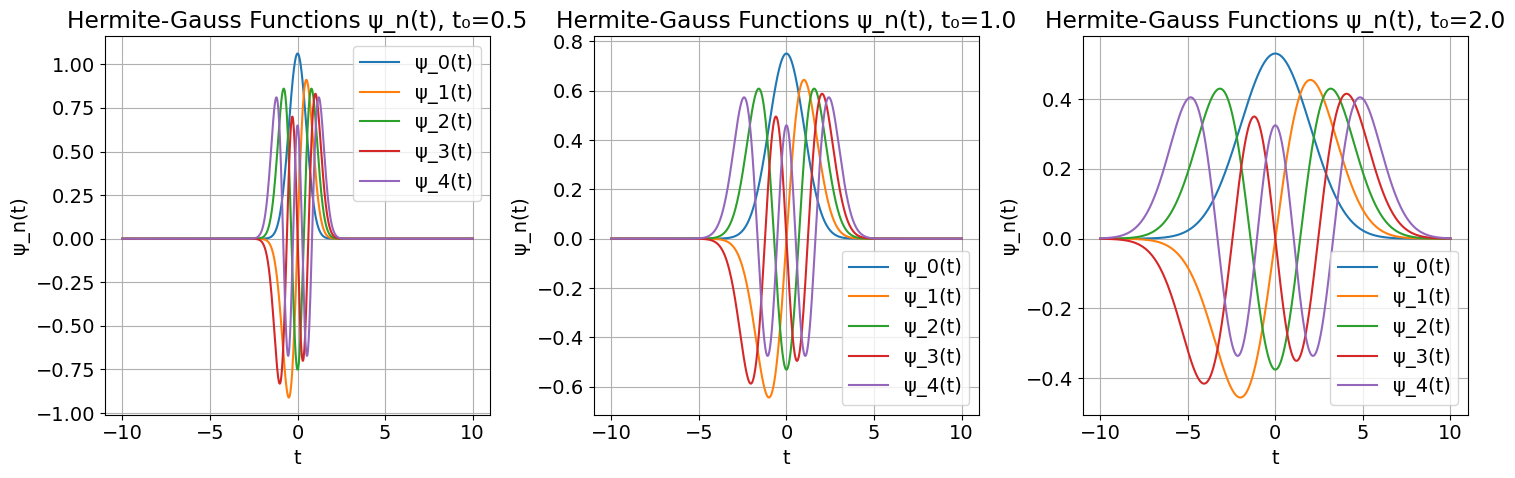

In [ ]:
# Create a range of x values
x = torch.linspace(-1, 1, 100)

# Plot the first few Hermite polynomials
plt.figure(figsize=(10, 6))
for n in range(5):
    Hn = hermite_poly(n, x)
    plt.plot(x.numpy(), Hn.numpy(), label=f'H_{n}(x)')
plt.xlabel('x')
plt.ylabel('H_n(x)')
plt.title('Hermite Polynomials H_n(x)')
plt.legend()
plt.grid()
plt.xlim(-1, 1)
plt.show()


# %% cell 6b code

# Plot the first few Hermite-Gauss functions with different t0 values
t = torch.linspace(-10, 10, 1000)
t0_values = [0.5, 1.0, 2.0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, t0 in enumerate(t0_values):
    for n in range(5):
        psi_n = hermite_gauss_stable(n, t, t0)
        axes[i].plot(t.numpy(), psi_n.numpy(), label=f'ψ_{n}(t)')
    axes[i].set_xlabel('t')
    axes[i].set_ylabel('ψ_n(t)')
    axes[i].set_title(f'Hermite-Gauss Functions ψ_n(t), t₀={t0}')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()


### Analyze

Timing Analysis for Hermite-Gauss Function Computation
n =    0: Average time = 0.0403 ms (100 runs)
n =  200: Average time = 3.9145 ms (100 runs)
n =  400: Average time = 7.7848 ms (100 runs)
n =  600: Average time = 11.6479 ms (100 runs)
n =  800: Average time = 15.4281 ms (100 runs)
n = 1000: Average time = 19.5862 ms (100 runs)


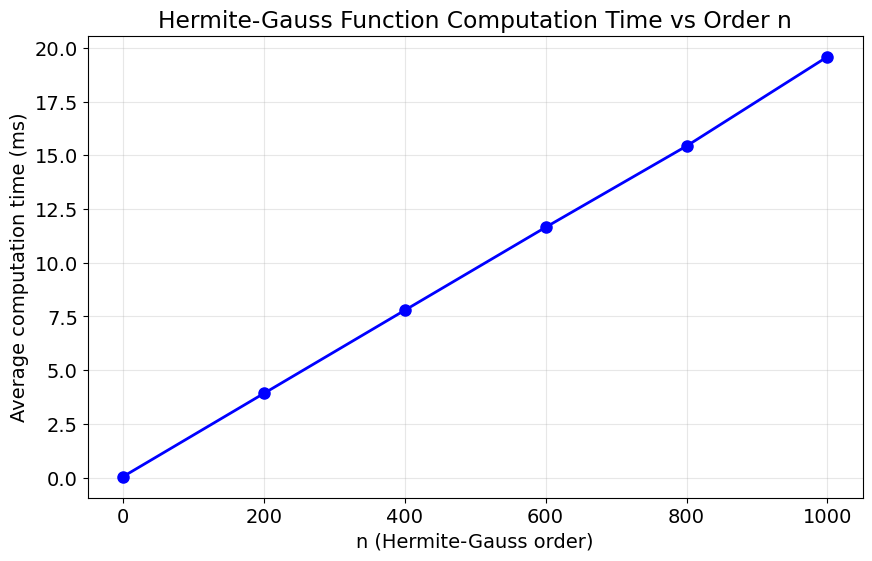

In [ ]:
# Timing analysis for Hermite-Gauss function computation
t = torch.linspace(-10, 10, 1000)
t0 = 1.0
n_values = [0, 200, 400, 600, 800, 1000]
avg_times = []

print("Timing Analysis for Hermite-Gauss Function Computation")
print("=" * 55)

for n in n_values:
    # Warm-up run
    _ = hermite_gauss_stable(n, t, t0)
    
    # Time multiple runs for better accuracy
    num_runs = 100
    start_time = time.time()
    
    for _ in range(num_runs):
        psi_n = hermite_gauss_stable(n, t, t0)
    
    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    avg_times.append(avg_time * 1000)  # Convert to milliseconds
    
    print(f"n = {n:4d}: Average time = {avg_time*1000:.4f} ms ({num_runs} runs)")

print("=" * 55)

# Plot the timing results
plt.figure(figsize=(10, 6))
plt.plot(n_values, avg_times, 'bo-', linewidth=2, markersize=8)
plt.xlabel('n (Hermite-Gauss order)')
plt.ylabel('Average computation time (ms)')
plt.title('Hermite-Gauss Function Computation Time vs Order n')
plt.grid(True, alpha=0.3)
plt.show()
